In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
# Directories for train, validation, and test data
train_dir = 'data/processed_images'
val_dir = 'data/images_train_test_val/validation'
test_dir = 'data/images_train_test_val/test'

# Data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Ensure order is maintained for ensemble predictions
)


Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [3]:
# Load saved models
vgg16_model = load_model('models/best_VIT_model.keras')
xception_model = load_model('models/best_Xception_model.keras')

# Predict using both models
preds_vgg16 = vgg16_model.predict(test_generator)
preds_xception = xception_model.predict(test_generator)

# Average the predictions
final_preds = (preds_vgg16 + preds_xception) / 2

# Convert predictions to class labels
final_class_preds = np.argmax(final_preds, axis=1)

# Mapping predictions back to original labels
class_indices = test_generator.class_indices
inverse_class_indices = {v: k for k, v in class_indices.items()}
final_class_labels = [inverse_class_indices[i] for i in final_class_preds]

# Save the results or proceed with further analysis
# Example: printing out the first 10 predictions
for i in range(10):
    print(f"Predicted: {final_class_labels[i]}, Actual: {test_generator.filenames[i].split('/')[0]}")

# Optional: Evaluate ensemble accuracy
test_labels = test_generator.classes
accuracy = np.mean(final_class_preds == test_labels)
print(f'Ensemble model accuracy: {accuracy}')

2024-07-25 03:20:35.514425: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-25 03:20:35.514477: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-25 03:20:35.514482: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-25 03:20:35.514762: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-25 03:20:35.514789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__ini

17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Predicted: agricultural, Actual: agricultural
Predicted: agricultural, Actual: agricultural
Predicted: agricultural, Actual: agricultural
Predicted: agricultural, Actual: agricultural
Predicted: agricultural, Actual: agricultural
Predicted: agricultural, Actual: agricultural
Predicted: agricultural, Actual: agricultural
Predicted: agricultural, Actual: agricultural
Predicted: agricultural, Actual: agricultural
Predicted: agricultural, Actual: agricultural
Ensemble model accuracy: 0.9266666666666666


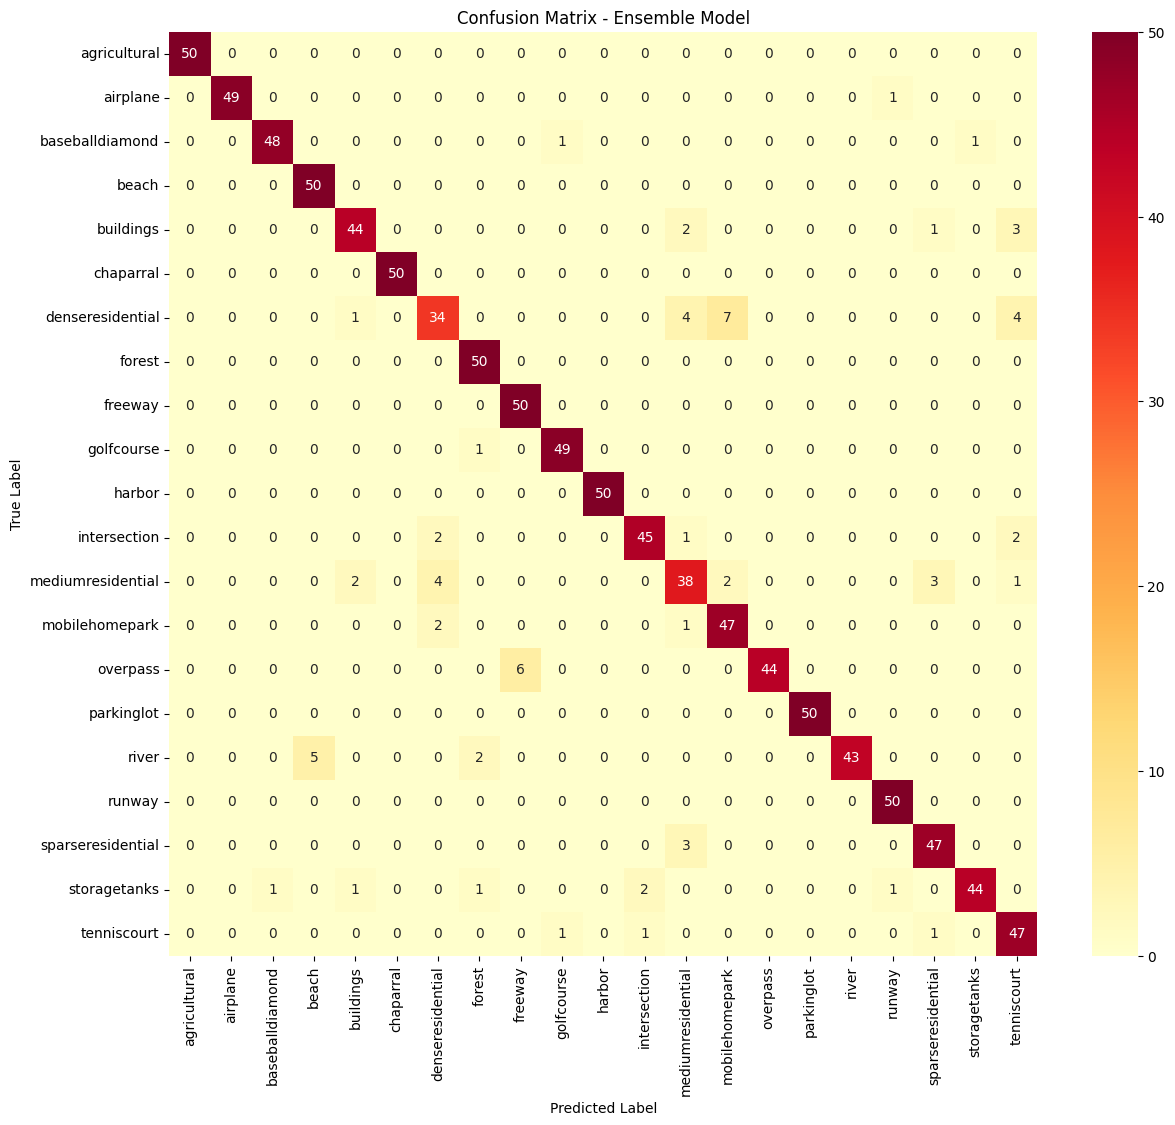

In [ ]:
# Confusion Matrix
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, final_class_preds)

# Plotting the Confusion Matrix
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd', xticklabels=inverse_class_indices.values(), yticklabels=inverse_class_indices.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Ensemble Model')
plt.savefig('confusion_matrix/ensemble_output.png')
plt.show()

In [ ]:
# Classification Report
report = classification_report(true_labels, final_class_preds, target_names=inverse_class_indices.values())
print(report)

                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        50
         airplane       1.00      0.98      0.99        50
  baseballdiamond       0.98      0.96      0.97        50
            beach       0.91      1.00      0.95        50
        buildings       0.92      0.88      0.90        50
        chaparral       1.00      1.00      1.00        50
 denseresidential       0.81      0.68      0.74        50
           forest       0.93      1.00      0.96        50
          freeway       0.89      1.00      0.94        50
       golfcourse       0.96      0.98      0.97        50
           harbor       1.00      1.00      1.00        50
     intersection       0.94      0.90      0.92        50
mediumresidential       0.78      0.76      0.77        50
   mobilehomepark       0.84      0.94      0.89        50
         overpass       1.00      0.88      0.94        50
       parkinglot       1.00      1.00      1.00       